**Notebook Contents:**
 * [Connect to database](#connect_to_database)
 * [Drivers](#drivers)
     1. [Which driver had the most F1 World Driver's Champion title?](#world_champion_title)
     2. [Which driver had obtained the most pole position?](#most_pole)
     3. [Which driver had the most points throughout their career?](#driver_most_points)
     4. [How many F1 drivers that actually won at least one race?](#driver_won_once)
     5. [What are the nationality of most F1 drivers?](#driver_nationality)
     
     
 * [Constructors](#constructors)
     1. [Who are the all time winning teams since 1950?](#all_time_win_team)
     2. [Which teams are the earliest to participate in F1?](#earliest_teams)
     3. [What are the F1 constructors nationality?](#constructors_nationality)
     4. [Who are the winning teams since the Hybrid era?](#winning_hybrid)
     5. [How are the performance of the 2021 teams before?](#2021_team_perf)
     

 * [F1 circuits and races](#circuits_race)
     1. [Where are most of the F1 tracks located?](#tracks_location)
     2. [What are the the fastest lap time for each Grand Prix?](#fastest_lap_time_gp)
     3. [How many F1 races are there for each season?](#season_race_count)  

<a id='connect_to_database'></a>
# Connect to database

In [145]:
# import libraries
import sqlalchemy
import pyodbc
import pandas as pd
import numpy as np

pyodbc.drivers()

['SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'SQL Server Native Client 11.0',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server']

In [146]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [147]:
%sql mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server

# Extract, transform, and visualization

In [148]:
#overall styling
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

sns.set_style("darkgrid")
palette = ['#004146','#018076','#03BFB5','#949398']
seq_palette_m = 'viridis'
seq_palette_h =  sns.dark_palette("#e76f51")
b_figsize = (14,8)

<a id='drivers'></a>
## Drivers

<a id='world_champion_title'></a>
### 1. Which driver had the most F1 World Driver's Champion title?

In [149]:
%%sql world_title <<

WITH cte as (
      SELECT CONCAT(forename, ' ', surname) AS driver_name,
             year, SUM(points) as race_points,
             RANK() OVER (PARTITION BY year ORDER BY SUM(points) DESC) as seqnum
      FROM results r JOIN 
           constructors c
           ON r.constructorId = c.constructorId JOIN
           drivers d
           ON r.driverId = d.driverId JOIN
           races rc
           ON r.raceId = rc.raceId
      GROUP BY CONCAT(forename, ' ', surname), year
     )
SELECT *
FROM cte
WHERE seqnum = 1 AND year<=2020;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable world_title


In [150]:
df_world_title = world_title.DataFrame()

In [151]:
df_world_title.tail()

,driver_name,year,race_points,seqnum
66,Nico Rosberg,2016,385.0,1
67,Lewis Hamilton,2017,363.0,1
68,Lewis Hamilton,2018,408.0,1
69,Lewis Hamilton,2019,413.0,1
70,Lewis Hamilton,2020,347.0,1


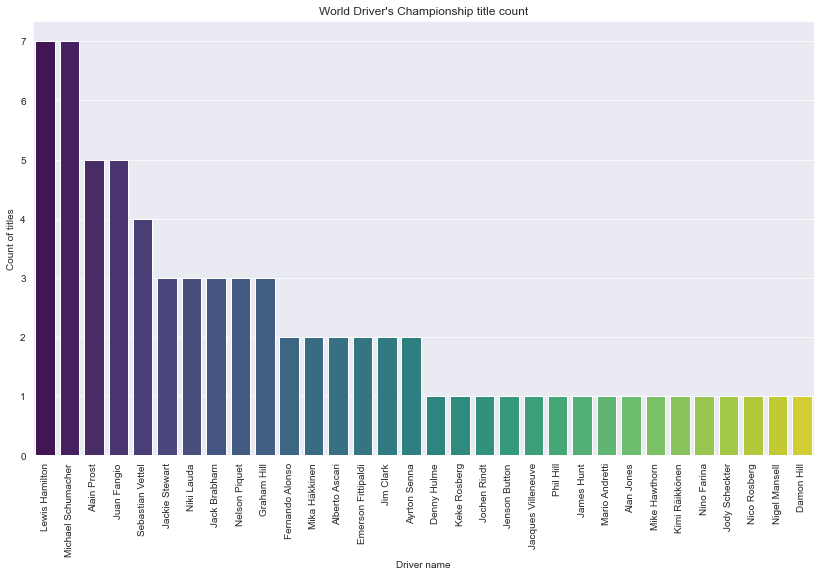

In [152]:
fig = plt.figure(figsize=b_figsize)
sns.countplot(data=df_world_title,x='driver_name',
              order=df_world_title['driver_name'].value_counts().index,
            palette=seq_palette_m)
plt.title("World Driver's Championship title count")
plt.xlabel("Driver name")
plt.ylabel("Count of titles")
plt.xticks(rotation=90)
plt.show()

**Description:** Since the 2021 season is stil on going, we will only consider the data up untill 2020. Here we can see that Lewis Hamilton and Michael Schumacher won the most World Driver Championship title. So far, only 32 driver's had won the title.

<a id='most_pole'></a>
### 2. Which driver had obtained the most pole position?

In [153]:
%%sql pole_position <<

WITH cte AS(

SELECT grid,
CONCAT(forename,' ',surname ) AS driver_name,
COUNT(driverRef) OVER(PARTITION BY driverRef) AS pole_count
FROM
    results AS r
    INNER JOIN races AS rc
    ON r.raceId = rc.raceId
    
    INNER JOIN constructors AS c
    ON r.constructorId = c.constructorId
    
    INNER JOIN drivers AS d
    ON r.driverId = d.driverId
        
WHERE grid = 1)

SELECT TOP 10 driver_name,MAX(pole_count) AS pole

FROM cte
GROUP BY driver_name
ORDER BY pole DESC

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable pole_position


In [154]:
df_pole_position = pole_position.DataFrame()

In [155]:
df_pole_position.head()

,driver_name,pole
0,Lewis Hamilton,100
1,Michael Schumacher,68
2,Ayrton Senna,65
3,Sebastian Vettel,57
4,Jim Clark,34


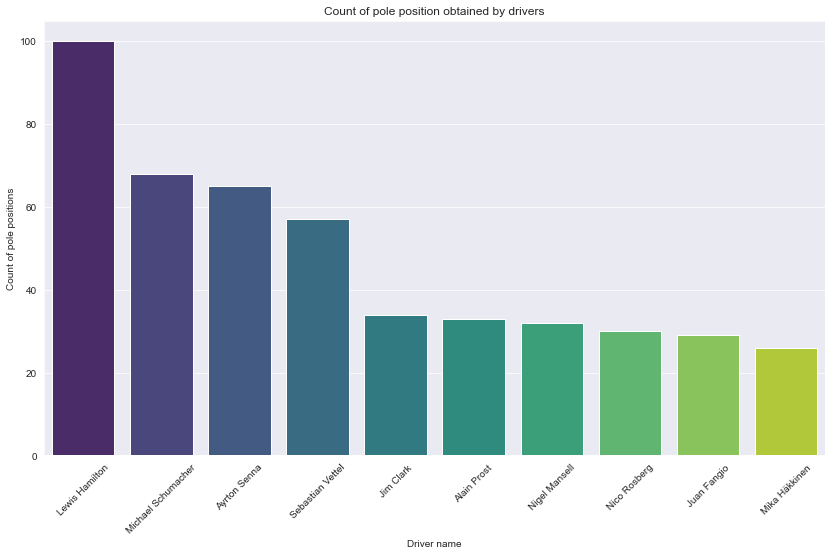

In [156]:
fig = plt.figure(figsize=b_figsize)
sns.barplot(data=df_pole_position,
            x='driver_name',
            y='pole',
            palette=seq_palette_m)
plt.title("Count of pole position obtained by drivers")
plt.xlabel("Driver name")
plt.ylabel("Count of pole positions")
plt.xticks(rotation=45)
plt.show()

**Description:** From the chart we can see that Lewis Hamilton had obtained 100 pole position. Considering that Lewis Hamilton entered F1 later than most of the drivers in this chart, he still manage to secure a lot of pole position in a short window of time.

<a id='driver_most_points'></a>
### 3. Which driver had the most points throughout their career?

In [157]:
%%sql f1_drivers_points <<

SELECT TOP 10 driver_name, SUM(driver_points) AS total_points
FROM
    (SELECT

        (CONVERT(DECIMAL, points)) AS driver_points,
        concat(forename, ' ', surname) AS driver_name

    FROM 
        results AS r

        INNER JOIN constructors AS c
        ON r.constructorId = c.constructorId

        INNER JOIN drivers AS d
        ON r.driverId = d.driverId

        INNER JOIN races AS rc
        ON r.raceId = rc.raceId

        WHERE points >= '1') AS subquery
    
GROUP BY driver_name
ORDER BY total_points DESC;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable f1_drivers_points


In [158]:
df_f1_drivers_points = f1_drivers_points.DataFrame()

In [159]:
df_f1_drivers_points.head()

,driver_name,total_points
0,Lewis Hamilton,3928
1,Sebastian Vettel,3048
2,Fernando Alonso,1919
3,Kimi Räikkönen,1864
4,Valtteri Bottas,1604


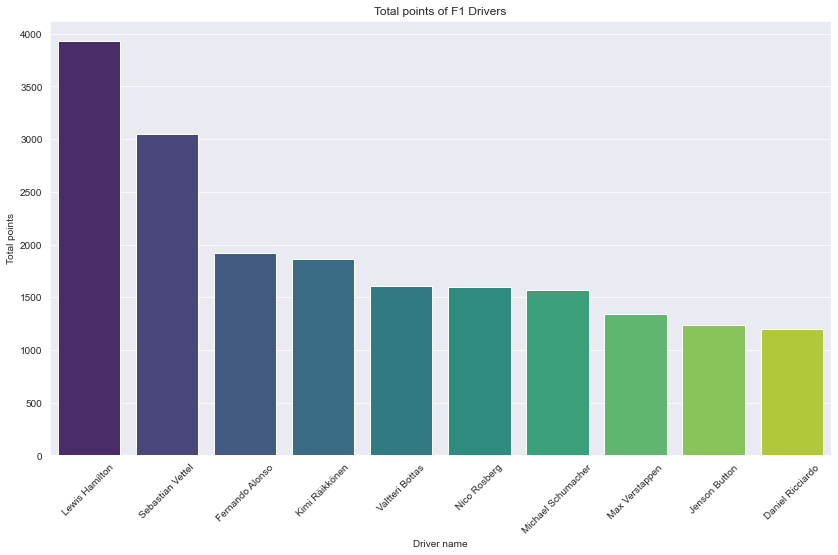

In [160]:
fig = plt.figure(figsize=b_figsize)
sns.barplot(data=df_f1_drivers_points, x='driver_name', y='total_points',palette='viridis')
plt.title("Total points of F1 Drivers")
plt.xlabel("Driver name")
plt.ylabel("Total points")
plt.xticks(rotation=45)
plt.show()

**Description:** In terms of total points, we can see that Lewis Hamilton had the most points in F1 history. Up to this point we can see that Lewis Hamilton had a great F1 career.

One interesting point that we can see here is that the drivers in this chart are mostly the drivers that are competing in the later seasons of F1. Could it possibly that the drivers are able to obtain more points during the later season in comparison to the earlier F1 season? We'll discuss that further in the "F1 circuits and races" section.

<a id='driver_won_once'></a>
### 4. How many F1 drivers that actually won at least one race?

In [161]:
%%sql f1_drivers_win_count <<

Select driver_name, COUNT(driver_name) AS frequency
FROM
    (SELECT
        concat(forename, ' ', surname) AS driver_name

    FROM 
        results AS r

        INNER JOIN constructors AS c
        ON r.constructorId = c.constructorId

        INNER JOIN drivers AS d
        ON r.driverId = d.driverId

        INNER JOIN races AS rc
        ON r.raceId = rc.raceId

        WHERE positionText = '1') AS subquery

GROUP BY driver_name
ORDER BY frequency DESC;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable f1_drivers_win_count


In [162]:
df_f1_drivers_win_count  = f1_drivers_win_count.DataFrame()

In [163]:
df_f1_drivers_win_count.tail()

,driver_name,frequency
105,Vittorio Brambilla,1
106,Sam Hanks,1
107,Richie Ginther,1
108,Robert Kubica,1
109,Rodger Ward,1


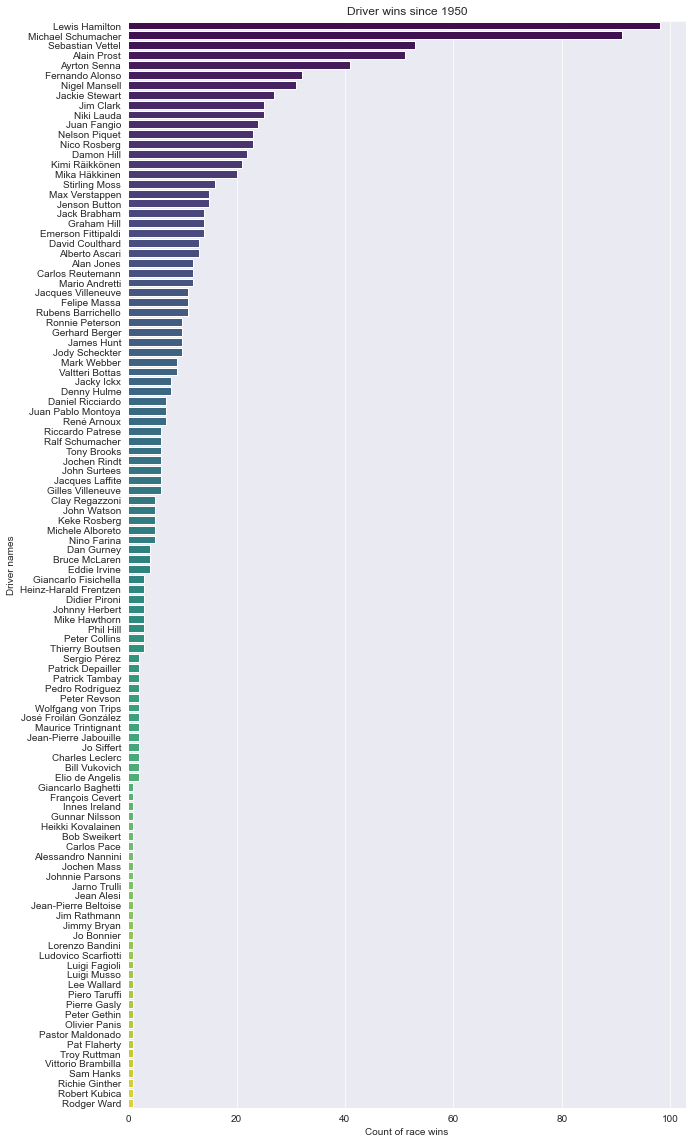

In [164]:
fig = plt.figure(figsize=(10,20))
sns.barplot(data=df_f1_drivers_win_count,
            x='frequency',
            y='driver_name',
            palette=seq_palette_m)

plt.title('Driver wins since 1950')
plt.ylabel('Driver names')
plt.xlabel('Count of race wins')
plt.show()

**Description:** From the data, we can see that there are 110 drivers that at least obtain 1 race win (1st position) in each of those races. From the frequency of wins, Lewis Hamilton is having nearly 100 wins (96 to be exact) which is the highest total wins since 1950.

<a id='driver_nationality'></a>
### 5. What are the nationality of most F1 drivers?

In [165]:
%%sql f1_drivers_nationality <<


SELECT
    nationality, COUNT(nationality) AS frequency

FROM 
    drivers
    
GROUP BY nationality
ORDER BY frequency DESC;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable f1_drivers_nationality


In [166]:
df_f1_drivers_nationality =f1_drivers_nationality.DataFrame()

In [167]:
df_f1_drivers_nationality.head()

,nationality,frequency
0,British,165
1,American,157
2,Italian,99
3,French,73
4,German,50


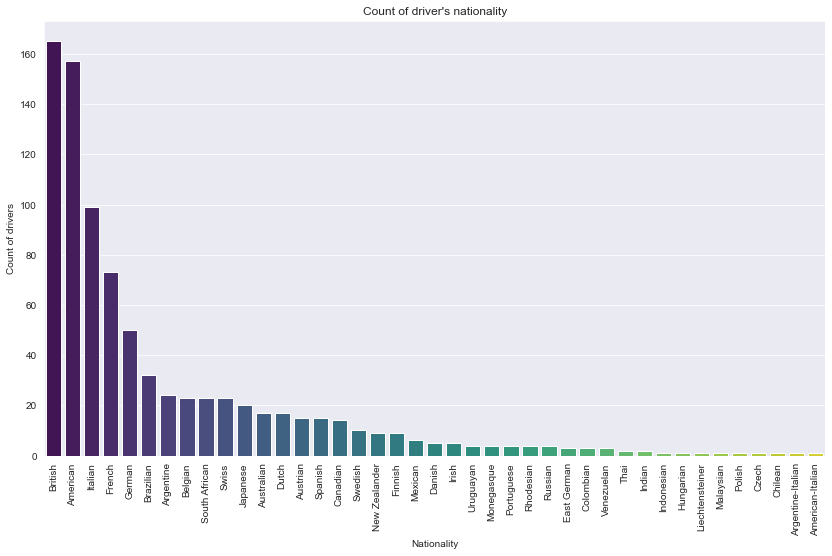

In [168]:
fig = plt.figure(figsize=b_figsize)
sns.barplot(data=df_f1_drivers_nationality, x='nationality', y='frequency',palette='viridis')
plt.title("Count of driver's nationality")
plt.xlabel("Nationality")
plt.ylabel("Count of drivers")
plt.xticks(rotation=90)
plt.show()

**Description:** Most of the Formula 1 drivers are British, which is quite as expected since most of the teams are based in UK. American drivers also come quite close in terms of total drivers but in terms of total teams. This shows that there is a possibility that the American drivers driver in teams that aren't American teams.

<a id='constructors'></a>
## Constructors

<a id='all_time_win_team'></a>
### 1. Who are the all time winning teams since 1950?

In [169]:
%%sql win_all_time <<

SELECT name,SUM(wins) AS total_wins
FROM 
    constructor_standings AS cs
    
    INNER JOIN constructors AS c
    ON cs.constructorId = c.constructorId
    
    INNER JOIN races AS r
    ON cs.raceId = r.raceId
    
    WHERE wins>=1
    GROUP BY name
    ORDER BY total_wins DESC;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable win_all_time


In [170]:
df_win_all_time = win_all_time.DataFrame()

In [171]:
df_win_all_time.head()

,name,total_wins
0,Ferrari,1856
1,McLaren,1595
2,Mercedes,1108
3,Williams,934
4,Red Bull,580


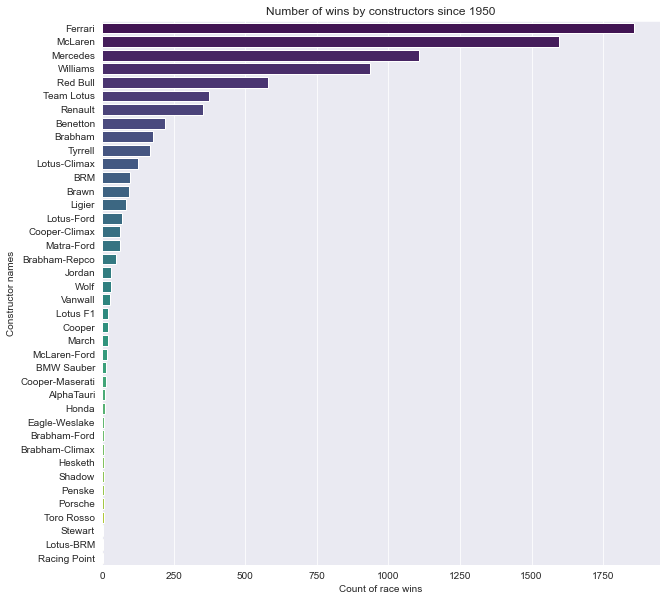

In [172]:
fig = plt.figure(figsize=(10,10))
sns.barplot(data=df_win_all_time,
            x='total_wins',
            y='name',
            palette=seq_palette_m)
plt.title('Number of wins by constructors since 1950')

plt.xlabel("Count of race wins")
plt.ylabel("Constructor names")
plt.show()

<a id='earliest_team'></a>
### 2. Which teams are the earliest to participate in F1?

In [173]:
%%sql team_orgin_date <<

SELECT name, MAX(DATEDIFF(year, date,CURRENT_TIMESTAMP)) AS team_age_years, MIN(date) AS first_race

FROM 
    constructor_standings AS cs
    
    INNER JOIN constructors AS c
    ON cs.constructorId = c.constructorId
    
    INNER JOIN races AS r
    ON cs.raceId = r.raceId
    
    GROUP BY name
    ORDER BY team_age_years DESC;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable team_orgin_date


In [174]:
df_team_orgin_date = team_orgin_date.DataFrame()

In [175]:
df_team_orgin_date.head(5)

,name,team_age_years,first_race
0,Maserati,63,1958-01-19 00:00:00.0000000
1,Ferrari,63,1958-01-19 00:00:00.0000000
2,Team Lotus,63,1958-05-18 00:00:00.0000000
3,BRM,63,1958-05-18 00:00:00.0000000
4,Connaught,63,1958-05-18 00:00:00.0000000


**Description:** From the table, we can see that among the eraliest team to participate since the inaugural season is Maserati, Ferrari, and Cooper. The list also includes Team Lotus and BRM. Just out of curiosity, let's see the teams that are recently created. 

In [176]:
df_team_orgin_date.tail(5)

,name,team_age_years,first_race
154,Manor Marussia,6,2015-03-29 00:00:00.0000000
155,Haas F1 Team,5,2016-03-20 00:00:00.0000000
156,Racing Point,2,2019-03-17 00:00:00.0000000
157,AlphaTauri,1,2020-07-05 00:00:00.0000000
158,Alpine F1 Team,0,2021-03-28 00:00:00.0000000


**Description:** Alpine team seems to be the most recently created constructors team followed by AlphaTauri and Racing Point. 3 years before that, Haas F1 Team starts their first F1 debut with Manor Marussia on the year before it. Apparently, Manor Marussia is short-lived and no longer participating in F1. Next, let's visualize all of the team age in one plot.

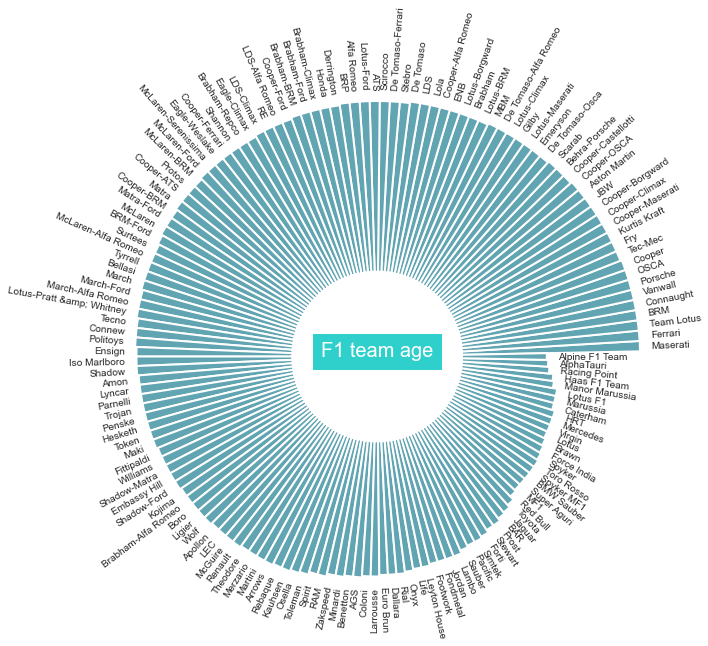

In [177]:
# import pandas for data wrangling

def circular_plot(dataframe,value,item,title):
    # Build a dataset

    # Reorder the dataframe
    df = dataframe
    
    # sort (I've sorted the data before so there's no need to sort again)
    # df = dataframe.sort_values(by=[value])

    # initialize the figure
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111, polar=True)
    ax.text(x=17,y=0,s=title,backgroundcolor="#2FD0CB", color='white',ha='center',size=20)
    plt.axis('off')

    # Constants = parameters controling the plot layout:
    upperLimit = 100
    lowerLimit = 30
    labelPadding = 4

    # Compute max and min in the dataset
    max = df[value].max()

    # Let's compute heights: they are a conversion of each item value in those new coordinates
    # In our example, 0 in the dataset will be converted to the lowerLimit (10)
    # The maximum will be converted to the upperLimit (100)
    slope = (max - lowerLimit) / max
    heights = slope * df[value] + lowerLimit

    # Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi / len(df.index)

    # Compute the angle each bar is centered on:
    indexes = list(range(1, len(df.index)+1))
    angles = [element * width for element in indexes]
    angles

    # Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=lowerLimit,
        linewidth=2, 
        edgecolor="white",
        color="#61a4b2",
    )
    

    # Add labels
    for bar, angle, height, label in zip(bars,angles, heights, df[item]):

        # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

        # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

        # Finally add the labels
        ax.text(
            x=angle, 
            y=lowerLimit + bar.get_height() + labelPadding, 
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor") 
        

title = 'F1 team age'
circular_plot(df_team_orgin_date,'team_age_years','name',title)

<a id='constructors_nationality'></a>
### 3. What are the F1 constructors nationality?

In [178]:
%%sql teams_nation <<

SELECT nationality, COUNT(nationality) AS count_teams

FROM 
    constructors AS c
    
    GROUP BY nationality
    ORDER BY count_teams DESC;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable teams_nation


In [179]:
df_teams_nation = teams_nation.DataFrame()

In [180]:
df_teams_nation.head()

,nationality,count_teams
0,British,86
1,American,39
2,Italian,29
3,French,13
4,German,10


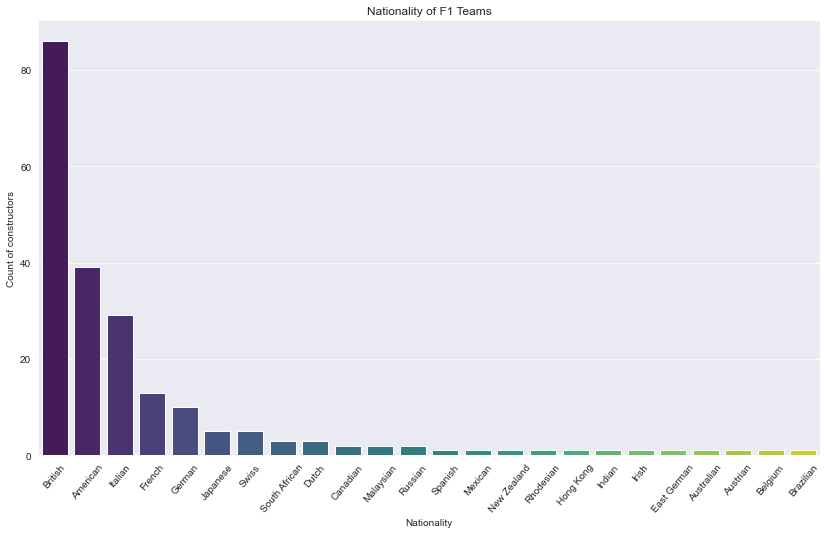

In [181]:
fig = plt.figure(figsize=b_figsize)
sns.barplot(data=df_teams_nation, x='nationality',
            y='count_teams',
            palette=seq_palette_m)
plt.title('Nationality of F1 Teams')
plt.xlabel("Nationality")
plt.ylabel("Count of constructors")
plt.xticks(rotation=50)
plt.show()

**Description:** From the chart, we can see most of the team's nationality is British which twice more than the count of American teams. [From this aricle by BBC](https://www.bbc.com/sport/formula1/23048643), it is mostly due to its history and heritage. The UK had lots of unused airfields for racing and testing. Similar to Silicon Valley, having a “motorsport valley” attracts a lot of engineers who live close to each other which leads to a high supply of quality workforce.

<a id='winning_hybrid'></a>
### 4. Who are the winning teams since the Hybrid era?

In [182]:
%%sql wins_hybrid <<

SELECT name,SUM(wins) AS total_wins
FROM 
    constructor_standings AS cs
    
    INNER JOIN constructors AS c
    ON cs.constructorId = c.constructorId
    
    INNER JOIN races AS r
    ON cs.raceId = r.raceId
    
    WHERE r.year >= '2014' AND wins>=1
    GROUP BY name
    ORDER BY total_wins DESC;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable wins_hybrid


In [183]:
df_wins_hybrid = wins_hybrid.DataFrame()

In [184]:
df_wins_hybrid

,name,total_wins
0,Mercedes,1054
1,Ferrari,205
2,Red Bull,166
3,AlphaTauri,10
4,Racing Point,2


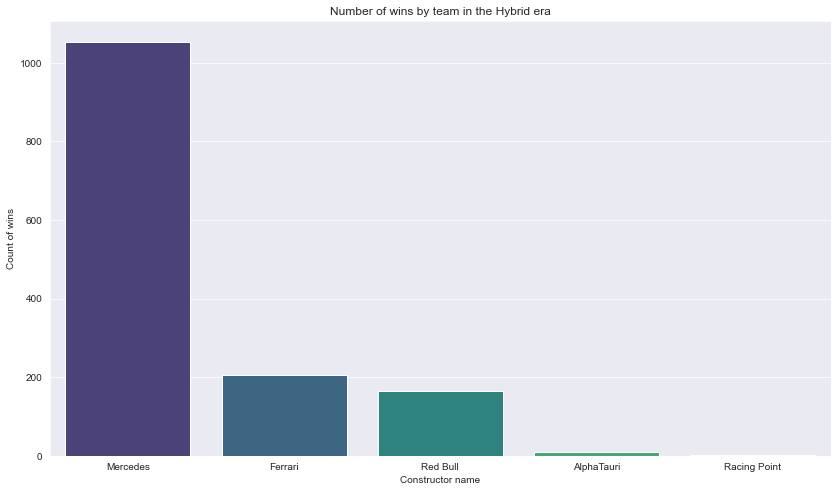

In [185]:
fig = plt.figure(figsize=b_figsize)
sns.barplot(data=df_wins_hybrid,
            x='name',
            y='total_wins',
            palette=seq_palette_m)
plt.title('Number of wins by team in the Hybrid era')
plt.xlabel("Constructor name")
plt.ylabel("Count of wins")
plt.show()

**Description:** From the analysis, we can see that the Mercedes team had totaly dominated the F1 championship during the hybrid era which is from 2014 and onwards. Interestingly, as we can see from the plot, most of the races are won by these 5 teams since 2014.

<a id='2021_team_perf'></a>
### 5. How are the performance of the 2021 teams before?

In [186]:
%%sql performance_2021_c <<

SELECT name AS constructor, YEAR(CONVERT(datetime, date)) AS year, SUM(CAST(points AS float)) total_points

FROM

    constructor_results AS cr

    INNER JOIN constructors AS c
    ON cr.constructorId = c.constructorId

    INNER JOIN races AS r
    ON cr.raceId = r.raceId
    
    WHERE name IN

        (SELECT DISTINCT c.name

        FROM 
            constructor_results AS cr

            INNER JOIN constructors AS c
            ON cr.constructorId = c.constructorId

            INNER JOIN races AS r
            ON cr.raceId = r.raceId

           WHERE date >= Convert(datetime, '2020-12-31' ))
        
GROUP BY YEAR(CONVERT(datetime, date)),name
ORDER BY year;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable performance_2021_c


In [187]:
df_performance_2021_c =performance_2021_c.DataFrame()

In [188]:
df_performance_2021_c.head()

,constructor,year,total_points
0,Ferrari,1956,21.0
1,Ferrari,1958,61.0
2,Aston Martin,1959,0.0
3,Ferrari,1959,38.0
4,Aston Martin,1960,0.0


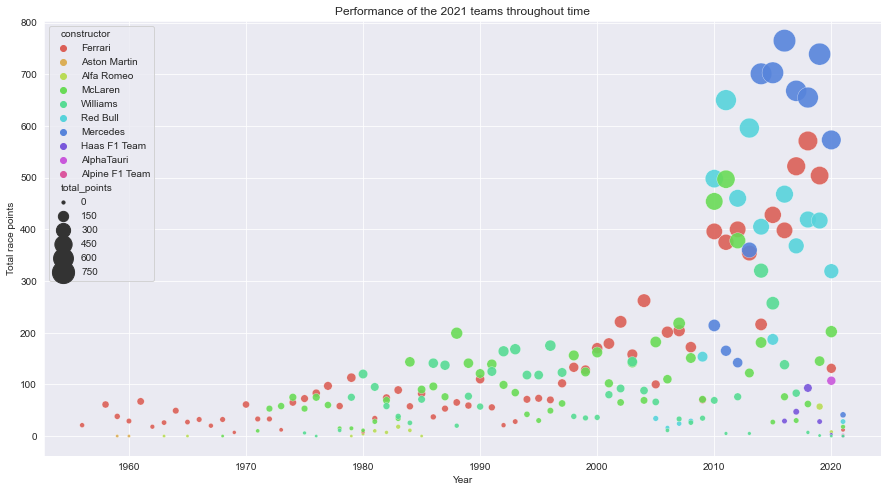

In [189]:
fig = plt.figure(figsize=(15,8))

sns.scatterplot(
    data=df_performance_2021_c,
    x="year",
    y='total_points',
    hue="constructor",
    size='total_points',
    sizes=(10,500),
    alpha=0.9,
    palette="hls"
)
plt.title("Performance of the 2021 teams throughout time")
plt.xlabel("Year")
plt.ylabel("Total race points")
plt.show()

**Description:** From the plot, we can see that Ferarri are among the oldest team to compete in the 2021 followed by Aston Martin and Alfa Romeo. It seems like the last two aforementioned constructors haven't score any significant points past 1970. This may be due to the teams hasn't participated for a while and making their return at the 2020 season.

We can also see that Red Bull had been winning a lot of points upon the year 2010 as well as the Mercedes team earliest obtained points. Even though they starts participating races in the later seasons, it seems like the team dominates the season beyond 2014 which is the start of the hybrid era.

What's even interesting is that Ferrari had a sudden drop of points nearing the 2020 season. [From this article](https://www.autosport.com/f1/news/binotto-ferrari-performance-so-far-in-2021-is-a-relief/6494159/), it seems like the Ferrari team's car for that season is suffering from performance and design issues.

<a id='circuits_race'></a>
## F1 circuits and races

<a id='tracks_location'></a>
### 1. Where are most of the F1 tracks located?

In [190]:
%%sql circuit_map <<

SELECT 
    name,
    location,
    country,
    lat,
    lng,
    CONVERT(INT,alt) as alt
FROM
    circuits

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable circuit_map


In [191]:
df_circuit_map = circuit_map.DataFrame()

In [192]:
df_circuit_map.dtypes

name         object
location     object
country      object
lat         float64
lng         float64
alt           int64
dtype: object

In [193]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.world_110m.url, 'countries')
circuits = df_circuit_map

background = alt.Chart(states, title='F1 Circuits location').mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('equalEarth').properties(
    width=500,
    height=300
)

points = alt.Chart(circuits).mark_circle().encode(
    longitude='lng:Q',
    latitude='lat:Q',
    size=alt.value(100),
    tooltip=('name','country','location'),
    color=alt.Color('alt', scale=alt.Scale(scheme=seq_palette_m))
)

background + points

alt.LayerChart(...)

**Description:** As we can see from the map, we can see that most of the F1 race tracks are mostly in the Europe and North America. In Asia, there are more track on the East in camparison to the South East. Most of the tracks are at sea level. The track that is very further from sea level which is the Autódromo Hermanos Rodríguez (Mexico city). Track altitudes are taken into consideration by teams since at lower pressures of high altitudes, air molecules spread out more so the air becomes less dense. This will greatly affect the aerodynamics of the car.

<a id='fastest_lap_time_gp'></a>
### 2. What are the the fastest lap time for each Grand Prix?

In [194]:
%%sql fastest_lap <<

WITH cte as (
      SELECT
    race_name,
    CONCAT(forename, ' ', surname) AS driver_name,
    MIN(l.milliseconds) as time_milli,
    RANK() OVER (PARTITION BY race_name ORDER BY MIN(l.milliseconds)) as seqnum
    FROM 
    
        lap_times AS l
    
        INNER JOIN races AS r
        ON l.raceId = r.raceId

        INNER JOIN drivers AS d
        ON l.driverId = d.driverId
    
    GROUP BY race_name, CONCAT(forename, ' ', surname)

     )
SELECT

race_name,
driver_name,
COUNT(driver_name) OVER(PARTITION BY driver_name) AS driver_freq,
time_milli

FROM cte
WHERE seqnum = 1
ORDER BY race_name;

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable fastest_lap


In [195]:
df_fastest_lap = fastest_lap.DataFrame()

In [196]:
df_fastest_lap['time_delta'] = pd.to_timedelta(df_fastest_lap['time_milli'], unit='ms')

In [197]:
df_fastest_lap.style.background_gradient(cmap='PuBu')

,race_name,driver_name,driver_freq,time_milli,time_delta
0,70th Anniversary Grand Prix,Lewis Hamilton,8,88451,0 days 00:01:28.451000
1,Abu Dhabi Grand Prix,Lewis Hamilton,8,99283,0 days 00:01:39.283000
2,Argentine Grand Prix,Gerhard Berger,1,87981,0 days 00:01:27.981000
3,Australian Grand Prix,Michael Schumacher,6,84125,0 days 00:01:24.125000
4,Austrian Grand Prix,Max Verstappen,2,66200,0 days 00:01:06.200000
5,Azerbaijan Grand Prix,Charles Leclerc,1,103009,0 days 00:01:43.009000
6,Bahrain Grand Prix,Michael Schumacher,6,90252,0 days 00:01:30.252000
7,Belgian Grand Prix,Kimi Räikkönen,2,105108,0 days 00:01:45.108000
8,Brazilian Grand Prix,Valtteri Bottas,2,70540,0 days 00:01:10.540000
9,British Grand Prix,Michael Schumacher,6,78739,0 days 00:01:18.739000


**Description:** There are a total of 35 F1 tracks throughout history. We can also see that most of the fastest lap time is done by Lewis Hamilton where the fastest lap ever done by him is is the Canadian Grand Prix with a time of 1 minute and 07.058000 seconds.

One more thing that intrigue me is that despite being a driver to one of the slower car for the season, we can see that George Russell did the fastest lap in Sakhir GP. From [Wikipedia](https://en.wikipedia.org/wiki/2020_Sakhir_Grand_Prix), we can see that at that time George Russell is temporarily driving for Mercedes in Lewis Hamilton's car as a replacement driver due to Lewis having tested positive for Covid-19.

<a id='season_race_count'></a>
### 3. How many F1 races are there for each season?

In [198]:
%%sql org_race <<

SELECT year,COUNT(race_name) AS count
FROM
    races AS rc
    
    INNER JOIN circuits AS c
    ON rc.circuitId = c.circuitId

GROUP BY year
ORDER BY year

 * mssql+pyodbc://@DESKTOP-8RI327A\SQLEXPRESS/F1?driver=SQL+Server
Done.
Returning data to local variable org_race


In [199]:
df_org_race = org_race.DataFrame()

In [200]:
df_org_race['year'] = df_org_race['year'].astype(str)

In [201]:
df_org_race.head()

,year,count
0,1950,7
1,1951,8
2,1952,8
3,1953,9
4,1954,9


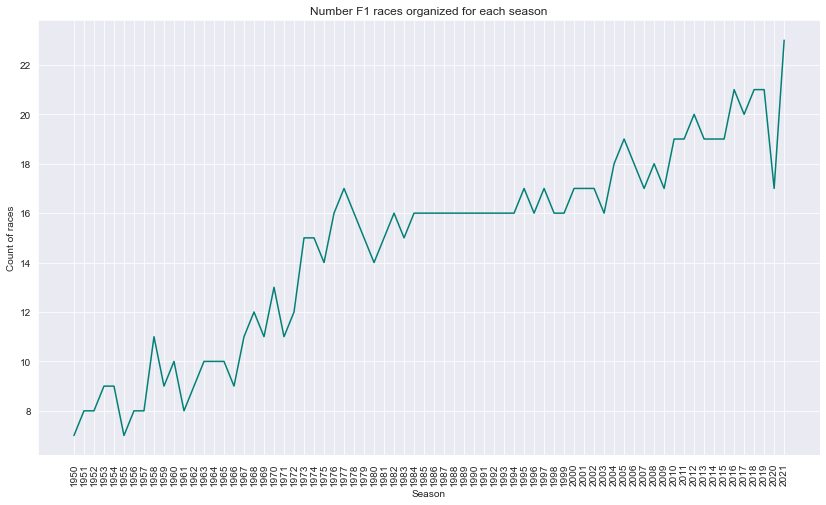

In [205]:
fig = plt.figure(figsize = b_figsize)
plt.title('Number F1 races organized for each season')
sns.lineplot(data=df_org_race, x='year', y='count',color=palette[1])
plt.xlabel('Season')
plt.ylabel('Count of races')
plt.xticks(rotation=90)
plt.show()

**Description:** Here we can see that the 2021 season had the most races which is 23. Initally in 1950, there were less than 10 races held. One key feature is that there is a consistent amount of races between 1984 and 1994 which is 16 races. It seems that the 16-race calendar was favoured by the FIA during that period. 

From the previous analysis of the driver points, we can see that the drivers that obtained the most overall points are the drivers that are from the later season of F1 (from 2010 and onwards). This somehow makes sense since during the later seasons, there are more races per season in comparison to the earlier seasons. This means that the drivers are able to obtain more points since there are more races.